In [25]:
import os
import json
import requests
from typing import Dict, List, Any, Literal
from IPython.display import display, Markdown, Image

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq

from langgraph.graph import StateGraph
from typing_extensions import TypedDict

In [26]:
# ===== API Configuration =====
# ຕັ້ງຄ່າ API Keys
GROQ_API_KEY = os.getenv("GROQ_API_KEY")  # ໃສ່ Groq API key
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")  # ໃສ່ Tavily API key  
WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")  # ໃສ່ Weather API key (OpenWeatherMap)

# ຕັ້ງຄ່າ environment variables
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [27]:
# ===== Tools Definition =====
@tool
def get_weather(city: str) -> str:
    """ເອົາຂໍ້ມູນສະພາບອາກາດຂອງເມືອງທີ່ກຳນົດ"""
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": city,
        "appid": WEATHER_API_KEY,
        "units": "metric",
        "lang": "en"
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        weather_info = {
            "city": data["name"],
            "country": data["sys"]["country"],
            "temperature": data["main"]["temp"],
            "feels_like": data["main"]["feels_like"],
            "humidity": data["main"]["humidity"],
            "description": data["weather"][0]["description"],
            "wind_speed": data["wind"]["speed"]
        }
        
        return json.dumps(weather_info, ensure_ascii=False)
    except Exception as e:
        return f"ບໍ່ສາມາດເອົາຂໍ້ມູນສະພາບອາກາດໄດ້: {str(e)}"

# Tavily search tool
search_tool = TavilySearchResults(max_results=3)

# ລາຍການເຄື່ອງມື
tools = [get_weather, search_tool]

In [28]:
# ===== LLM Setup =====
llm = ChatGroq(
    model="meta-llama/llama-4-maverick-17b-128e-instruct",
    temperature=0,
    max_tokens=3000
)

llm_with_tools = llm.bind_tools(tools)

In [29]:
# ===== State Definition =====
class PlanningState(TypedDict):
    messages: List[Any]
    plan: List[Dict]
    current_step: int
    completed_tasks: List[Dict]
    failed_tasks: List[Dict]
    final_result: str
    planning_complete: bool

# ===== Planning Functions =====
def create_plan(state: PlanningState):
    """ສ້າງແຜນການເຮັດວຽກ"""
    messages = state["messages"]
    user_query = messages[0].content if messages else ""
    
    planning_prompt = f"""ເຈົ້າແມ່ນ Planning Expert ທີ່ມີໜ້າທີ່ແບ່ງໜ້າວຽກໃຫຍ່ເປັນໜ້າວຽກຍ່ອຍ.

ມີເຄື່ອງມື 2 ຢ່າງ:
1. get_weather - ເອົາຂໍ້ມູນສະພາບອາກາດ
2. tavily_search_results_json - ຄົ້ນຫາຂໍ້ມູນທົ່ວໄປ

ຄຳຖາມຂອງຜູ້ໃຊ້: "{user_query}"

ຈົງວາງແຜນການເຮັດວຽກເປັນຂັ້ນຕອນທີ່ຊັດເຈນ:

ຕົວຢ່າງຮູບແບບ JSON response:
{{
    "analysis": "ການວິເຄາະຄຳຖາມ...",
    "plan": [
        {{
            "step": 1,
            "task": "ຄຳອະທິບາຍໜ້າວຽກ",
            "tool": "get_weather" ຫຼື "tavily_search_results_json",
            "parameters": {{"key": "value"}},
            "expected_output": "ຜົນລັບທີ່ຄາດວ່າຈະໄດ້",
            "fallback": "ແຜນສຳຮອງຖ້າລົ້ມເຫຼວ"
        }}
    ],
    "success_criteria": "ເງື່ອນໄຂຄວາມສຳເລັດ"
}}

ໃຫ້ແຜນທີ່ລະອຽດແລະເປັນລຳດັບ:"""

    response = llm.invoke([SystemMessage(content=planning_prompt)])
    print("ຜົນລັບຈາກການວິເຄາະຄຳຖາມ: ", response.content)
    try:
        # ພະຍາຍາມ parse JSON
        plan_data = json.loads(response.content)
        plan = plan_data.get("plan", [])
    except:
        # Fallback plan ຖ້າ JSON parsing ລົ້ມເຫຼວ
        if "weather" in user_query.lower() or "ອາກາດ" in user_query:
            plan = [{
                "step": 1,
                "task": "ເອົາຂໍ້ມູນສະພາບອາກາດ",
                "tool": "get_weather",
                "parameters": {"city": "Vientiane"},
                "expected_output": "ຂໍ້ມູນອຸນຫະພູມແລະສະພາບອາກາດ",
                "fallback": "ຊອກຫາຂໍ້ມູນອາກາດຈາກແຫຼ່ງອື່ນ"
            }]
        else:
            plan = [{
                "step": 1,
                "task": "ຄົ້ນຫາຂໍ້ມູນ",
                "tool": "tavily_search_results_json",
                "parameters": {"query": user_query[:50]},
                "expected_output": "ຂໍ້ມູນທີ່ກ່ຽວຂ້ອງ",
                "fallback": "ປັບປຸງ search query ແລະຄົ້ນໃໝ່"
            }]
    
    print(f"📋 ແຜນການເຮັດວຽກ: {len(plan)} ຂັ້ນຕອນ")
    for i, task in enumerate(plan, 1):
        print(f"   {i}. {task.get('task', 'ໜ້າວຽກບໍ່ຊັດເຈນ')}")
    
    return {
        "plan": plan,
        "current_step": 0,
        "planning_complete": True,
        "completed_tasks": [],
        "failed_tasks": []
    }

def execute_current_step(state: PlanningState):
    """set up current step"""
    plan = state["plan"]
    current_step = state["current_step"]
    
    if current_step >= len(plan):
        return {"current_step": current_step}
    
    current_task = plan[current_step]
    print(f"🔄 ກຳລັງປະຕິບັດຂັ້ນຕອນ {current_step + 1}: {current_task['task']}")
    
    try:
        tool_name = current_task["tool"]
        parameters = current_task.get("parameters", {})
        
        # ປະຕິບັດ tool
        if tool_name == "get_weather":
            city = parameters.get("city", "Vientiane")
            result = get_weather.invoke({"city": city})
        elif tool_name == "tavily_search_results_json":
            query = parameters.get("query", "")
            result = search_tool.invoke({"query": query})
        else:
            result = f"Tool {tool_name} ບໍ່ຮອງຮັບ"
        
        # ບັນທຶກຜົນສຳເລັດ
        completed_task = {
            "step": current_step + 1,
            "task": current_task["task"],
            "tool": tool_name,
            "result": str(result),
            "status": "success"
        }
        
        completed_tasks = state["completed_tasks"] + [completed_task]
        
        print(f"✅ ສຳເລັດ: {current_task['task']}")
        
        return {
            "current_step": current_step + 1,
            "completed_tasks": completed_tasks
        }
        
    except Exception as e:
        print(f"❌ ລົ້ມເຫຼວ: {current_task['task']} - {str(e)}")
        
        # ພະຍາຍາມ fallback strategy
        fallback_plan = current_task.get("fallback", "")
        
        failed_task = {
            "step": current_step + 1,
            "task": current_task["task"],
            "error": str(e),
            "fallback_attempted": fallback_plan,
            "status": "failed"
        }
        
        failed_tasks = state["failed_tasks"] + [failed_task]
        
        return {
            "current_step": current_step + 1,
            "failed_tasks": failed_tasks
        }

def synthesize_results(state: PlanningState):
    """ວິເຄາະຜົນລັບທັງໝົດ"""
    completed_tasks = state["completed_tasks"]
    failed_tasks = state["failed_tasks"]
    messages = state["messages"]
    original_query = messages[0].content if messages else ""
    
    synthesis_prompt = f"""ຈົງວິເຄາະຜົນລັບຈາກການປະຕິບັດແຜນການເຮັດວຽກ:

ຄຳຖາມຕົ້ນສະບັບ: "{original_query}"

ໜ້າວຽກທີ່ສຳເລັດ:
{json.dumps(completed_tasks, ensure_ascii=False, indent=2)}

ໜ້າວຽກທີ່ລົ້ມເຫຼວ:
{json.dumps(failed_tasks, ensure_ascii=False, indent=2)}

ຈົງສ້າງຄຳຕອບສຸດທ້າຍ:
1. ຕອບຄຳຖາມຂອງຜູ້ໃຊ້ໂດຍກົງ
2. ວິເຄາະຂໍ້ມູນຈາກໜ້າວຽກທີ່ສຳເລັດ
3. ອະທິບາຍໂດຍຫຍໍ້ວ່າເຮັດຫຍັງແນ່
4. ລະບຸຂໍ້ຈຳກັດຖ້າມີໜ້າວຽກລົ້ມເຫຼວ
5. ຕອບເປັນພາສາລາວທີ່ເຂົ້າໃຈງ່າຍ"""

    response = llm.invoke([SystemMessage(content=synthesis_prompt)])
    
    final_result = response.content
    print("📊 ວີເຄາະຜົນລັບສຳເລັດ")
    
    return {"final_result": final_result}

# ===== Router Functions =====
def should_continue_planning(state: PlanningState) -> Literal["execute", "synthesize"]:
    """ກຳນົດວ່າຄວນເຮັດຫຍັງຕໍ່ໄປ"""
    if not state.get("planning_complete", False):
        return "execute"
    
    current_step = state["current_step"]
    plan = state["plan"]
    
    if current_step < len(plan):
        return "execute"
    else:
        return "synthesize"

def should_continue_execution(state: PlanningState) -> Literal["execute", "synthesize"]:
    """ກຳນົດວ່າຄວນສືບຕໍ່ປະຕິບັດຫຼືວິເຄາະຜົນ"""
    current_step = state["current_step"]
    plan = state["plan"]
    
    if current_step < len(plan):
        return "execute"
    else:
        return "synthesize"

# ===== Graph Construction =====
def create_planning_agent():
    """ສ້າງ Planning-Based Agent"""
    workflow = StateGraph(PlanningState)
    
    # ເພີ່ມ nodes
    workflow.add_node("planner", create_plan)
    workflow.add_node("executor", execute_current_step)
    workflow.add_node("synthesizer", synthesize_results)
    
    # ຕັ້ງ entry point
    workflow.set_entry_point("planner")
    
    # ເພີ່ມ conditional edges
    workflow.add_conditional_edges(
        "planner",
        should_continue_planning,
        {
            "execute": "executor",
            "synthesize": "synthesizer"
        }
    )
    
    workflow.add_conditional_edges(
        "executor", 
        should_continue_execution,
        {
            "execute": "executor",
            "synthesize": "synthesizer"
        }
    )
    
    # End at synthesizer
    workflow.add_edge("synthesizer", "__end__")
    
    return workflow.compile()

# ===== Execution Function =====
def run_planning_agent(query: str):
    """ແລ່ນ Planning-Based Agent"""
    agent = create_planning_agent()
    
    # ສ້າງ initial state
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "plan": [],
        "current_step": 0,
        "completed_tasks": [],
        "failed_tasks": [],
        "final_result": "",
        "planning_complete": False
    }
    
    print(f"🎯 Planning-Based Agent ກຳລັງປະມວນຜົນ: {query}\n")
    
    # ແລ່ນ agent
    result = agent.invoke(initial_state)
    
    # ສະແດງຜົນສຳເລັດ/ລົ້ມເຫຼວ
    print("\n📈 ສະຫຼຸບການປະຕິບັດ:")
    print(f"   ✅ ສຳເລັດ: {len(result['completed_tasks'])} ໜ້າວຽກ")
    print(f"   ❌ ລົ້ມເຫຼວ: {len(result['failed_tasks'])} ໜ້າວຽກ")
    
    # ສະແດງຜົນໄຟນອນ
    final_response = result["final_result"]
    display(Markdown(f"## ຄຳຕອບຈາກ Planning-Based Agent\n\n{final_response}"))
    
    return result

# ===== Advanced Planning Features =====
class AdaptivePlanningAgent:
    """Planning Agent ທີ່ສາມາດປັບແຜນໄດ້"""
    
    def __init__(self):
        self.max_retries = 2
        self.adaptive_planning = True
    
    def run_with_adaptation(self, query: str):
        """ການປັບແຜນແບບອັດຕະໂນມັດ"""
        attempt = 0
        
        while attempt < self.max_retries:
            attempt += 1
            print(f"🔄 ຄວາມພະຍາຍາມທີ {attempt}")
            
            try:
                result = run_planning_agent(query)
                
                # ກວດສອບຜົນສຳເລັດ
                if len(result['failed_tasks']) == 0:
                    print("🎉 ແຜນສຳເລັດໃນຄວາມພະຍາຍາມທີ", attempt)
                    return result
                elif attempt < self.max_retries:
                    print(f"⚠️ ມີໜ້າວຽກລົ້ມເຫຼວ, ຈະລອງໃໝ່...")
                    continue
                else:
                    print("❌ ໝົດຄວາມພະຍາຍາມແລ້ວ")
                    return result
                    
            except Exception as e:
                print(f"💥 Error ໃນຄວາມພະຍາຍາມທີ {attempt}: {e}")
                if attempt == self.max_retries:
                    raise
        
        return None

🚀 ເລີ່ມຕົ້ນ Planning-Based Agent...

📊 ສະແດງ Planning-Based Agent Graph:


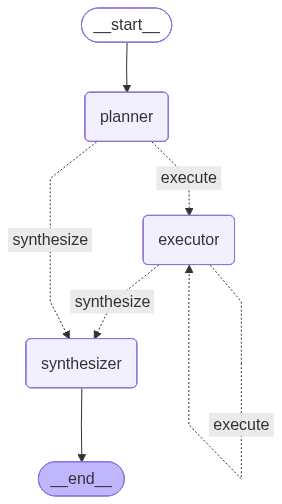


🌤️ ທົດສອບແຜນງ່າຍ - ສະພາບອາກາດ
🎯 Planning-Based Agent ກຳລັງປະມວນຜົນ: ສະພາບອາກາດໃນວຽງຈັນເປັນແນວໃດ?

ຜົນລັບຈາກການວິເຄາະຄຳຖາມ:  ```json
{
  "analysis": "ຄຳຖາມກ່ຽວກັບສະພາບອາກາດໃນວຽງຈັນ, ຕ້ອງການຂໍ້ມູນສະພາບອາກາດທີ່ແນ່ນອນ",
  "plan": [
    {
      "step": 1,
      "task": "ຄົ້ນຫາສະພາບອາກາດໃນວຽງຈັນ",
      "tool": "get_weather",
      "parameters": {"location": "ວຽງຈັນ"},
      "expected_output": "ຂໍ້ມູນສະພາບອາກາດປັດຈຸບັນໃນວຽງຈັນ",
      "fallback": "ໃຊ້ tavily_search_results_json ຄົ້ນຫາຂໍ້ມູນສະພາບອາກາດຖ້າ get_weather ລົ້ມເຫຼວ"
    }
  ],
  "success_criteria": "ໄດ້ຮັບຂໍ້ມູນສະພາບອາກາດໃນວຽງຈັນທີ່ແນ່ນອນ"
}
```
📋 ແຜນການເຮັດວຽກ: 1 ຂັ້ນຕອນ
   1. ເອົາຂໍ້ມູນສະພາບອາກາດ
🔄 ກຳລັງປະຕິບັດຂັ້ນຕອນ 1: ເອົາຂໍ້ມູນສະພາບອາກາດ
✅ ສຳເລັດ: ເອົາຂໍ້ມູນສະພາບອາກາດ
📊 ວີເຄາະຜົນລັບສຳເລັດ

📈 ສະຫຼຸບການປະຕິບັດ:
   ✅ ສຳເລັດ: 1 ໜ້າວຽກ
   ❌ ລົ້ມເຫຼວ: 0 ໜ້າວຽກ


## ຄຳຕອບຈາກ Planning-Based Agent

1. ສະພາບອາກາດໃນວຽງຈັນໃນປະຈຸບັນແມ່ນຝົນຕົກເບົາໆ ອຸນຫະພູມ 27 ອົງສາເຊ ຄວາມຊື່ນຢູ່ທີ່ 89% ອຸນຫະພູມຮູ້ສຶກວ່າ 32 ອົງສາເຊ ຄວາມໄວລົມ 0.42 ແມັດຕໍ່ວິນາທີ.

2. ຂໍ້ມູນຈາກໜ້າວຽກທີ່ສຳເລັດສະແດງໃຫ້ເຫັນວ່າອຸນຫະພູມໃນວຽງຈັນແມ່ນ 27.48 ອົງສາເຊ, ຄວາມຊື່ນຢູ່ທີ່ 89%, ມີຝົນຕົກເບົາໆ ແລະ ຄວາມໄວລົມຕ່ຳ.

3. ໜ້າວຽກໄດ້ປະຕິບັດການຮ້ອງຂໍເພື່ອດຶງຂໍ້ມູນສະພາບອາກາດປັດຈຸບັນຂອງວຽງຈັນໂດຍໃຊ້ເຄື່ອງມື `get_weather`, ເຊິ່ງສົ່ງຄືນຂໍ້ມູນລະອຽດກ່ຽວກັບສະພາບອາກາດ.

4. ບໍ່ມີໜ້າວຽກທີ່ລົ້ມເຫຼວໃນການປະຕິບັດແຜນການເຮັດວຽກນີ້.

5. ຄຳຕອບຖືກສ້າງຂຶ້ນໂດຍອີງໃສ່ຂໍ້ມູນທີ່ໄດ້ຮັບຈາກໜ້າວຽກທີ່ປະຕິບັດສຳເລັດ ແລະ ບໍ່ມີຂໍ້ຈຳກັດໃດໆ ຕໍ່ກັບຄຳຕອບທີ່ສ້າງຂຶ້ນນີ້.


🔍 ທົດສອບແຜນຊັບຊ້ອນ - ຄົ້ນຫາ + ວິເຄາະ
🎯 Planning-Based Agent ກຳລັງປະມວນຜົນ: ຫາຂໍ້ມູນເກມ PS5 ໃໝ່ ແລະວິເຄາະວ່າຄຸ້ມຄ່າຊື້ບໍ່

ຜົນລັບຈາກການວິເຄາະຄຳຖາມ:  {
 "analysis": "ຄຳຖາມຂອງຜູ້ໃຊ້ກ່ຽວກັບການຫາຂໍ້ມູນເກມ PS5 ໃໝ່ ແລະວິເຄາະວ່າຄຸ້ມຄ່າຊື້ບໍ່. ຂັ້ນຕອນທຳອິດຄວນຈະເປັນການຄົ້ນຫາເກມ PS5 ໃໝ່ລ່າສຸດກ່ອນ, ຈາກນັ້ນຈຶ່ງວິເຄາະຂໍ້ມູນທີ່ໄດ້",
 "plan": [
 {
 "step": 1,
 "task": "ຄົ້ນຫາເກມ PS5 ໃໝ່ລ່າສຸດ",
 "tool": "tavily_search_results_json",
 "parameters": {"query": "ເກມ PS5 ໃໝ່ລ່າສຸດ"},
 "expected_output": "ລາຍຊື່ເກມ PS5 ໃໝ່ພ້ອມລາຍລະອຽດ",
 "fallback": "ຖ້າການຄົ້ນຫາລົ້ມເຫຼວ, ໃຫ້ລອງຄົ້ນຫາໃໝ່ດ້ວຍຄຳຄົ້ນທີ່ຄ້າຍຄືກັນ"
 },
 {
 "step": 2,
 "task": "ເກັບກຳຂໍ້ມູນເກມທີ່ຄົ້ນພົບ",
 "tool": "ບໍ່ໃຊ້ເຄື່ອງມື",
 "parameters": {},
 "expected_output": "ຂໍ້ມູນເກມທີ່ຖືກເກັບກຳ",
 "fallback": "ບໍ່ມີແຜນສຳຮອງ"
 },
 {
 "step": 3,
 "task": "ວິເຄາະຄວາມຄຸ້ມຄ່າຂອງເກມທີ່ຄົ້ນພົບ",
 "tool": "ບໍ່ໃຊ້ເຄື່ອງມື",
 "parameters": {},
 "expected_output": "ການວິເຄາະຄວາມຄຸ້ມຄ່າຂອງເກມ",
 "fallback": "ຖ້າການວິເຄາະຜິດພາດ, ໃຫ້ກັບໄປຄົ້ນຫາໃໝ່ຫຼືປັບປຸງຂໍ້ມູ

## ຄຳຕອບຈາກ Planning-Based Agent

ຂ້ອຍຈະສ້າງຄຳຕອບສຸດທ້າຍໂດຍອີງໃສ່ຜົນລັບຈາກການປະຕິບັດແຜນການເຮັດວຽກທີ່ໃຫ້ມາ.

1. ຕອບຄຳຖາມຂອງຜູ້ໃຊ້ໂດຍກົງ:
ເກມ PS5 ໃໝ່ທີ່ຄົ້ນພົບມີຫຼາຍເກມທີ່ໜ້າສົນໃຈເຊັ່ນ "Animal Bomber", "Wild Rumble", "Soulstone Survivors", "Shinobi: Art of Vengeance", "Hirogami", ແລະ "Wuchang: Fallen Feathers". ເກມເຫຼົ່ານີ້ມີລັກສະນະທີ່ແຕກຕ່າງກັນໄປເຊັ່ນ ແອັກຊັນ, ໂຣເກລໄລກ, ແລະຊູມເກມ. ການຕັດສິນຄວາມຄຸ້ມຄ່າຊື້ຂຶ້ນກັບຄວາມສົນໃຈສ່ວນບຸກຄົນໃນແຕ່ລະເກມ.

2. ວິເຄາະຂໍ້ມູນຈາກໜ້າວຽກທີ່ສຳເລັດ:
- ໜ້າວຽກທີ 1: ຄົ້ນຫາເກມ PS5 ໃໝ່ລ່າສຸດໂດຍໃຊ້ "tavily_search_results_json" ແລະພົບເຫັນເກມໃໝ່ຫຼາຍເກມທີ່ມີຄະແນນສູງ.
- ໜ້າວຽກທີ 2 ແລະ 3: ບໍ່ໄດ້ໃຊ້ເຄື່ອງມືເພື່ອເກັບກຳຂໍ້ມູນແລະວິເຄາະຄວາມຄຸ້ມຄ່າ, ແຕ່ຍັງສຳເລັດໂດຍບໍ່ມີຜົນລັບທີ່ມີສາລະ.

3. ອະທິບາຍໂດຍຫຍໍ້ວ່າເຮັດຫຍັງແນ່:
ຂັ້ນຕອນນີ້ໄດ້ຄົ້ນຫາເກມ PS5 ໃໝ່ລ່າສຸດໂດຍໃຊ້ເຄື່ອງມືຄົ້ນຫາ ແລະໄດ້ລາຍຊື່ເກມໃໝ່ໆ ທີ່ໜ້າສົນໃຈ.

4. ລະບຸຂໍ້ຈຳກັດ:
ໜ້າວຽກທີ 2 ແລະ 3 ບໍ່ໄດ້ໃຊ້ເຄື່ອງມືເພື່ອເກັບກຳຂໍ້ມູນແລະວິເຄາະຄວາມຄຸ້ມຄ່າ, ເຊິ່ງເຮັດໃຫ້ບໍ່ມີຂໍ້ມູນລະອຽດກ່ຽວກັບເກມທີ່ຄົ້ນພົບ.

5. ຕອບເປັນພາສາລາວທີ່ເຂົ້າໃຈງ່າຍ:
ເກມ PS5 ໃໝ່ທີ່ພົບເຫັນປະກອບມີເກມແອັກຊັນ, ໂຣເກລໄລກ, ແລະເກມຍິງບານ. ຖ້າທ່ານສົນໃຈໃນເກມປະເພດໃດໜຶ່ງ, ມັນອາດຈະຄຸ້ມຄ່າທີ່ຈະຊື້. ຢ່າງໃດກໍຕາມ, ການຕັດສິນໃຈຊື້ຄວນອີງໃສ່ຄວາມສົນໃຈສ່ວນບຸກຄົນໃນເນື້ອຫາ ແລະ ຄຸນນະພາບຂອງເກມ.


🔄 ທົດສອບ Adaptive Planning Agent
🔄 ຄວາມພະຍາຍາມທີ 1
🎯 Planning-Based Agent ກຳລັງປະມວນຜົນ: ປຽບທຽບລາຄາ ລາຄາເກມ PS5 ໃນຫຼາຍປະເທດ

ຜົນລັບຈາກການວິເຄາະຄຳຖາມ:  ຂ້ອຍຈະວາງແຜນການເຮັດວຽກເພື່ອປຽບທຽບລາຄາເກມ PS5 ໃນຫຼາຍປະເທດໂດຍໃຊ້ເຄື່ອງມືທີ່ມີຢູ່.

```json
{
  "analysis": "ຄຳຖາມນີ້ຕ້ອງການການປຽບທຽບລາຄາເກມ PS5 ໃນຫຼາຍປະເທດ. ເຄື່ອງມື 'tavily_search_results_json' ສາມາດໃຊ້ເພື່ອຄົ້ນຫາລາຄາເກມ PS5 ໃນປະເທດຕ່າງໆ.",
  "plan": [
    {
      "step": 1,
      "task": "ຄົ້ນຫາລາຄາເກມ PS5 ໃນປະເທດທີ່ສຳຄັນ (ເຊັ່ນ: ອາເມລິກາ, ຢີ່ປຸ່ນ, ເອີຣົບ)",
      "tool": "tavily_search_results_json",
      "parameters": {"query": "ລາຄາເກມ PS5 ໃນປະເທດອາເມລິກາ, ຢີ່ປຸ່ນ, ເອີຣົບ"},
      "expected_output": "ລາຄາເກມ PS5 ໃນປະເທດອາເມລິກາ, ຢີ່ປຸ່ນ, ເອີຣົບ",
      "fallback": "ຖ້າການຄົ້ນຫາລົ້ມເຫຼວ, ໃຫ້ຄົ້ນຫາລາຄາເກມ PS5 ໃນປະເທດດຽວກ່ອນ"
    },
    {
      "step": 2,
      "task": "ເກັບກຳລາຄາເກມ PS5 ໃນປະເທດທີ່ຄົ້ນຫາໄດ້",
      "tool": "ບໍ່ມີເຄື່ອງມືສະເພາະ",
      "parameters": {},
      "expected_output": "ລາຄາເກມ PS5 ໃນຮູບແບບທີ່ສາມາດປຽບທຽບໄດ້",
 

## ຄຳຕອບຈາກ Planning-Based Agent

1. ຕອບຄຳຖາມຂອງຜູ້ໃຊ້ໂດຍກົງ: ລາຄາເກມ PS5 ແຕກຕ່າງກັນໄປຕາມປະເທດ ໂດຍລາຄາທີ່ພົບເຫັນຢູ່ Amazon.com ແມ່ນຢູ່ລະຫວ່າງ $428.90 ຫາ $699.00.

2. ວິເຄາະຂໍ້ມູນຈາກໜ້າວຽກທີ່ສຳເລັດ: ຂໍ້ມູນທີ່ໄດ້ຈາກການຄົ້ນຫາສະແດງໃຫ້ເຫັນລາຄາ PS5 ຢູ່ Amazon.com ມີຫຼາຍລຸ້ນ ບໍ່ວ່າຈະເປັນ PS5 Digital Edition (slim) ຫຼື PS5 Pro. ລາຄາທີ່ຖືກທີ່ສຸດແມ່ນຢູ່ທີ່ $428.90 ສຳລັບ PS5 Digital Edition (slim) ທີ່ມີຄະແນນ 4.2 ດາວ. ໃນຂະນະດຽວກັນ, ລຸ້ນທີ່ມີລາຄາເຕັມທີ່ສຸດແມ່ນຢູ່ທີ່ $699.00.

3. ອະທິບາຍໂດຍຫຍໍ້ວ່າເຮັດຫຍັງແນ່: ໜ້າວຽກທີ່ສຳເລັດແມ່ນການຄົ້ນຫາຂໍ້ມູນກ່ຽວກັບລາຄາ PS5 ໃນຫຼາຍປະເທດໂດຍສະເພາະແມ່ນການກະກຽມຂໍ້ມູນຈາກໜ້າເວັບ Amazon.com ເຊິ່ງສະແດງລາຄາ ແລະລາຍລະອຽດຂອງລຸ້ນຕ່າງໆຂອງ PS5.

4. ລະບຸຂໍ້ຈຳກັດຖ້າມີໜ້າວຽກລົ້ມເຫຼວ: ບໍ່ມີໜ້າວຽກລົ້ມເຫຼວໃນການປະຕິບັດແຜນການເຮັດວຽກນີ້.

5. ຕອບເປັນພາສາລາວທີ່ເຂົ້າໃຈງ່າຍ: ເກມ PS5 ມີລາຄາແຕກຕ່າງກັນໄປຕາມປະເທດ ໂດຍສະເພາະແມ່ນລາຄາໃນ Amazon.com ທີ່ມີລາຄາລະຫວ່າງ $428.90 ຫາ $699.00 ສຳລັບລຸ້ນຕ່າງໆຂອງ PS5 ເຊັ່ນ PS5 Digital Edition (slim) ແລະ PS5 Pro.

🎉 ແຜນສຳເລັດໃນຄວາມພະຍາຍາມທີ 1

✅ ການທົດສອບ Planning-Based Agent ສຳເລັດ!


In [30]:
if __name__ == "__main__":
    print("🚀 ເລີ່ມຕົ້ນ Planning-Based Agent...")
    
    # ສ້າງ agent ເພື່ອສະແດງ graph
    agent = create_planning_agent()
    
    # ສະແດງ Planning Agent Graph ຄັ້ງດຽວ
    print("\n📊 ສະແດງ Planning-Based Agent Graph:")
    try:
        display(Image(agent.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(f"ບໍ່ສາມາດສະແດງ graph ໄດ້: {e}")
    
    # ຄຳຖາມທຳອິດ - ງ່າຍໆ
    print("\n" + "="*60)
    print("🌤️ ທົດສອບແຜນງ່າຍ - ສະພາບອາກາດ")
    print("="*60)
    result1 = run_planning_agent("ສະພາບອາກາດໃນວຽງຈັນເປັນແນວໃດ?")
    
    # ຄຳຖາມທີສອງ - ຊັບຊ້ອນກວ່າ
    print("\n" + "="*60)
    print("🔍 ທົດສອບແຜນຊັບຊ້ອນ - ຄົ້ນຫາ + ວິເຄາະ")
    print("="*60)
    result2 = run_planning_agent("ຫາຂໍ້ມູນເກມ PS5 ໃໝ່ ແລະວິເຄາະວ່າຄຸ້ມຄ່າຊື້ບໍ່")
    
    # ທົດສອບ Adaptive Planning
    print("\n" + "="*60)
    print("🔄 ທົດສອບ Adaptive Planning Agent")
    print("="*60)
    adaptive_agent = AdaptivePlanningAgent()
    result3 = adaptive_agent.run_with_adaptation("ປຽບທຽບລາຄາ ລາຄາເກມ PS5 ໃນຫຼາຍປະເທດ")
    
    print("\n✅ ການທົດສອບ Planning-Based Agent ສຳເລັດ!")
